# Social learning simulations
In this notebook we explore traditional and modified models for social learning on the interactions between political communities on the platform Reddit.

## Loading data
- G: A set of $t$ adjacency matrices, where $t$ is the number of time steps
- List of subreddits sourced from `political_subreddits_labeled.txt`

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import colors
from scipy.special import softmax
plt.rcParams['legend.title_fontsize'] = 'large'

In [ ]:
def load_political_subs(filename):
    lst = []
    positions = []
    lines = open(filename, "r")
    while (True):
        line = lines.readline()
        if not line:
            break
        name, position = line.strip().split(",")
        lst.append(name)
        positions.append(position)
    lines.close()
    return lst, positions

In [ ]:
means = { "left": 0.25, "center": 0.5, "right": 0.75 }
colors = {"left": "blue", "center": "lightgrey", "right": "maroon"}
subs, positions = load_political_subs("political_subreddits_labeled.txt")
mean_beliefs = [means[position] for position in positions]
color_mapping = [colors[position] for position in positions]

In [ ]:
# Set up mappings for dates and individual subreddits
dates = {}
timestep = 0
for yr in range(2014, 2018):
    for m in range(1, 13):
        if yr >= 2017 and m > 4:
            break
        m = m if m >= 10 else f"0{m}"
        dates[f"{yr}-{m}"] = timestep
        timestep += 1

# Mapping from communities to indices
indices = {}
for i in range(len(subs)):
    indices[subs[i]] = i

feminisms was negative towards worldnews
anarcho_capitalism was negative towards economics
anarcho_capitalism was negative towards worldnews
libertarian was negative towards anarcho_capitalism
anarchism was negative towards anarcho_capitalism
socialism was negative towards worldnews
libertarian was negative towards politics
conservatives was negative towards politics
republican was negative towards politics
mensrights was negative towards worldnews
anarcho_capitalism was negative towards worldnews
anarcho_capitalism was negative towards todayilearned
mensrights was negative towards news
mensrights was negative towards news
libertarian was negative towards worldnews
mensrights was negative towards worldnews
liberal was negative towards conservative
mensrights was negative towards worldnews
libertarian was negative towards politics
libertarian was negative towards todayilearned
conservative was negative towards mensrights
socialism was negative towards todayilearned
anarcho_capitalism wa

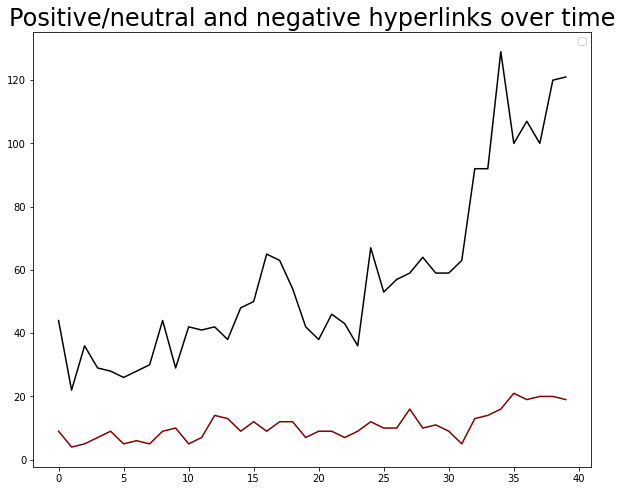

In [108]:
# Populate graph G
def load_political_data(dates, indices, filename):
    G = np.zeros((len(dates), len(indices), len(indices)))
    edges = open(filename, "r")
    negativity = np.zeros(len(dates))
    
    # Retrieve relevant weightings
    while(True):
        line = edges.readline()
        if not line:
            break
        arr = line.strip().split("\t")
        [u, v, post_id, timestamp, label] = arr[:5]
        if u.lower() in subs and v.lower() in subs:
            t = dates[timestamp[:7]]
            u_i = indices[u]
            v_i = indices[v]
            if int(label) == -1:
                negativity[t] += 1
                print(u + " was negative towards " + v)
            else:
                G[t][u_i][v_i] += 1

    edges.close()

    G_discrete = np.array(G, copy=True)

    # Plotting the evolution (done)
    # dates = list(dates.keys())
    # for t in range(G.shape[0]):
    #     fig = plt.figure(figsize=(10,8))
    #     ax = plt.gca()
    #     ax.set_title(dates[t])
    #     GViz = nx.from_numpy_matrix(G[t],create_using=nx.DiGraph)
    #     pos = nx.shell_layout(GViz)
    #     nx.draw(GViz, pos, node_color=color_mapping)
    #     fig.savefig(f"viz/animation/{t}.png")

    # Adjust self-weightings to be max of possible links - your links
    # Softmax each of the rows
    # Result: weight matrix at each time step

    # Plot negativity over time
    fig = plt.figure(figsize=(10,8))
    plt.rc('axes', titlesize=24)
    plt.title("Positive/neutral and negative hyperlinks over time")
    print(np.sum(G_discrete, axis=(1,2)))
    print(negativity)
    line1 = plt.plot(np.arange(len(dates)), negativity, color="maroon")
    line2 = plt.plot(np.arange(len(dates)), np.sum(G_discrete, axis=(1,2)), color="black")
    plt.legend([line1, line2], ['Negative interactions', 'Positive/neutral interactions'])
    fig.savefig(f"viz/plots/negativity.png")

    for t in range(G.shape[0]):
        external_citations = np.sum(G[t], axis=1)
        self_influence = np.diag(np.max(external_citations) - external_citations)
        G[t] += self_influence
        divisor = np.sum(G[t], axis=1).reshape(G[t].shape[0], -1)
        indices_zero = np.where(divisor == 0)
        divisor[indices_zero] = 1
        G[t] = G[t]/divisor
        # G[t] = softmax(G[t], axis=1)
        assert(np.allclose(np.sum(G[t], axis=1), np.ones(G.shape[0])))
    
    return G, G_discrete

G, G_discrete = load_political_data(dates, indices, "soc-redditHyperlinks-title.tsv")

In [ ]:
np.any(np.isnan(G))

False

# Implementing network update methods

## General Social Learning Class
This class contains:
- **Initialization** number of nodes, weights, initial states
- **Disagreement index**
- **Plotting functions** for both disagreement and beliefs

In [101]:
class SocialLearning:
    def __init__(self, N, W=None, initial_states=None):
        self.N = N
    
        if W is None:
            W = np.random.random_sample(size=(N, N))
        W /= np.sum(W, axis=1).reshape((N, -1))
        self.W = W

        assert(np.all(np.vstack((self.W >= 0, self.W <= 1))))

        if initial_states is None:
            initial_states = np.random.random_sample(size=self.N)
        
        self.initial_states = initial_states
        self.beliefs = np.array([self.initial_states])

    # Vector of network disagreement indices over all beliefs
    # https://www.pnas.org/content/pnas/110/15/5791.full.pdf
    def ndi(self):
        disagreement = np.zeros(len(self.beliefs))
        for t in range(disagreement.shape[0]):
            beliefs = self.beliefs[t]
            for i in range(self.N):
                for j in range(i+1, self.N):
                    disagreement[t] += self.W[i][j] * (beliefs[i] - beliefs[j])**2
        return disagreement

    def plot_beliefs(self, title="Beliefs plot"):
        x = np.arange(0, self.beliefs.shape[0])
        fig = plt.figure(figsize=(10,8))
        plt.rc('axes', titlesize=24)
        for i in range(self.N):
            plt.plot(x, self.beliefs[:,i])
            plt.title(title)
        plt.show()
        print(np.mean(self.beliefs[-1]))
        fig.savefig(f"viz/plots/{title}.png")

    def plot_disagreement(self, title="Diagreement plot"):
        disagreement = self.ndi()
        x = np.arange(0, self.beliefs.shape[0])
        fig = plt.figure(figsize=(10,8))
        plt.rc('axes', titlesize=24)
        plt.plot(x, disagreement)
        plt.title(title)
        plt.show()
        fig.savefig(f"viz/plots/{title}.png")

    # plot before and after
    # self.beliefs[0] is the original vector, self.beliefs[-1] is the final set of beliefs
    def plot_before_and_after(self, title="Agent Opinion Before and After Plot"):
        original_beliefs = np.reshape(self.beliefs[0], (5, 8))
        final_beliefs = np.reshape(self.beliefs[-1], (5, 8))

        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

        x = np.arange(0,9,1)
        y = np.arange(0,6,1)
        cm1 = colors.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])

        # plt.title(title)
        ax1.pcolormesh(x,y,original_beliefs,cmap=cm1,vmin=0,vmax=1)
        ax2.pcolormesh(x,y,final_beliefs,cmap=cm1,vmin=0,vmax=1)


        plt.show()
        fig.savefig(f"viz/plots/{title}.png")



## Degroot Learning
- DeGroot Learning (Degroot 1972)
- Biased DeGroot Learning (Dandekar et al. 2014)

In [102]:
class DeGroot(SocialLearning):
    def __init__(self, N, W=None, initial_states=None, bias=None):
        SocialLearning.__init__(self, N, W, initial_states)
        if bias is None:
            bias = np.zeros(N)
        self.bias = bias
        assert(np.all(self.beliefs <= 1))
        assert(np.all(self.beliefs >= 0))

    def update(self, iterations=1):
        for iteration in range(iterations):
            old_beliefs = self.beliefs[-1]
            new_beliefs = old_beliefs @ self.W.T
            assert(np.all(new_beliefs <= 1))
            assert(np.all(new_beliefs >= 0))
            self.beliefs = np.vstack((self.beliefs, new_beliefs))

    # Based on the update rule from Dandekar Goel and Lee
    # https://www.pnas.org/content/pnas/110/15/5791.full.pdf
    def biased_update(self, iterations=1):
        for iteration in range(iterations):
            old_beliefs = self.beliefs[-1]
            new_beliefs = np.zeros(self.N)
            self_weights = np.diag(self.W)
            s_t = old_beliefs @ (self.W.T - np.diag(self_weights)) # beliefs of neighbors
            d = np.sum(self.W, axis=1) - self_weights # weighted degree of neighbors

            for i in range(self.N):
                xit = old_beliefs[i]
                bi = self.bias[i]
                num = self.W[i][i] * xit + xit**bi * s_t[i]
                denom = self.W[i][i] + xit**bi*s_t[i] + (1-xit)**bi * (d[i] - s_t[i])
                new_beliefs[i] = num / denom
            self.beliefs = np.vstack((self.beliefs, new_beliefs))

## Bounded confidence model
- Insert citation

In [103]:
class BoundedConfidenceModel(SocialLearning):
    def __init__(self, N, W=None, initial_states=None, epsilon=0.5, mu=0.25, rewire=False):
        # No weights for this model, just neighbors - input symmetric with 1s and 0s
        SocialLearning.__init__(self, N, W, initial_states)
        self.eps = epsilon
        self.mu = mu
        if rewire is True:
            for i in range(self.N):
                for j in range(self.N):
                    if abs(initial_states[i] - initial_states[j]) < self.eps:
                        W[i][j] = 0

    def update(self, iterations=1):
        for iteration in range(iterations):
            old_beliefs = self.beliefs[-1]
            new_beliefs = self.beliefs[-1]
            for i in range(self.N):
                diff = old_beliefs - old_beliefs[i]

                # include if there exists an edge and difference between opinions < eps
                indices = np.all(np.vstack((abs(diff) < self.eps, self.W[i] > 0)), axis=0)
                if len(diff[indices]) > 0:
                    new_beliefs[i] = max(min(old_beliefs[i] + self.mu * np.mean(diff[indices]), 1), 0)
            self.beliefs = np.vstack((self.beliefs, new_beliefs))

## Voter Model

In [104]:
class VoterModel(SocialLearning):
    def __init__(self, N, W=None, initial_states=None, bias=None, stubbornness=None):
        # No weights for this model, just neighbors - input symmetric with 1s and 0s
        SocialLearning.__init__(self, N, W, initial_states)
        if bias is None:
            bias = np.zeros(self.N)
        if stubbornness is None:
            stubbornness = np.zeros(self.N)
        self.bias = bias
        self.stubbornness = stubbornness

    def update(self, iterations=1):
        for iteration in range(iterations):
            old_beliefs = self.beliefs[-1]
            new_beliefs = self.beliefs[-1]
            for i in range(self.N):
                # Choose random belief out of neighbors
                neighbors = self.W[i] > 0
                new_beliefs[i] = np.random.choice(old_beliefs[neighbors])
            self.beliefs = np.vstack((self.beliefs, new_beliefs))

    def biased_update(self, iterations=1):
        for iteration in range(iterations):
            old_beliefs = self.beliefs[-1]
            new_beliefs = np.zeros(self.N)
            for i in range(self.N):
                # By default, stay the same
                new_beliefs[i] = old_beliefs[i]

                # Choose random belief out of neighbors
                neighbors = self.W[i] > 0
                neighbors[i] = False # exclude self
                diffs = abs(old_beliefs[neighbors] - old_beliefs[i])
                sorted_neighbors = old_beliefs[neighbors][np.argsort(diffs)]
                
                # First success
                biased_index = np.random.geometric(self.bias[i]) - 1

                if biased_index < len(sorted_neighbors):
                    new_beliefs[i] = sorted_neighbors[biased_index]
                # If unassigned and not stubborn
                elif np.random.random() > self.stubbornness[i]:
                    bounds = [old_beliefs[i], sorted_neighbors[0]]
                    new_beliefs[i] = np.random.uniform(min(bounds), max(bounds))

            self.beliefs = np.vstack((self.beliefs, new_beliefs))

In [ ]:
B = np.array([0, 0.5, 0, 0.7])
A = np.array([0.5, 0.4, 0.2, 0.6])
neighbors = B > 0
diffs = abs(A[neighbors] - 0.2)
print(diffs)
sorted_neighbors = A[neighbors][np.argsort(diffs)]
sorted_neighbors

[0.2 0.4]


array([0.4, 0.6])

# Experiments
Distributions of initial beliefs:
- `left`: \[0, 0.5\]
- `center`: \[0.25, 0.75\]
- `right`: \[0.5, 1\]

## Setup

In [105]:
N = len(indices)
lows = np.array(mean_beliefs) - 0.25
highs = np.array(mean_beliefs) + 0.25
initial_beliefs = np.random.uniform(low=lows, high=highs, size=N)
G_total = np.sum(G_discrete, axis=0)
W = G_total / np.sum(G_total, axis=1).reshape(N, -1)

G_degroot = np.array(G_total, copy=True)
external_citations = np.sum(G_total, axis=1)
self_influence = np.diag(np.max(external_citations) - external_citations)
G_degroot += self_influence
W_degroot = G_degroot / np.sum(G_degroot, axis=1).reshape(N, -1)

## Degroot models

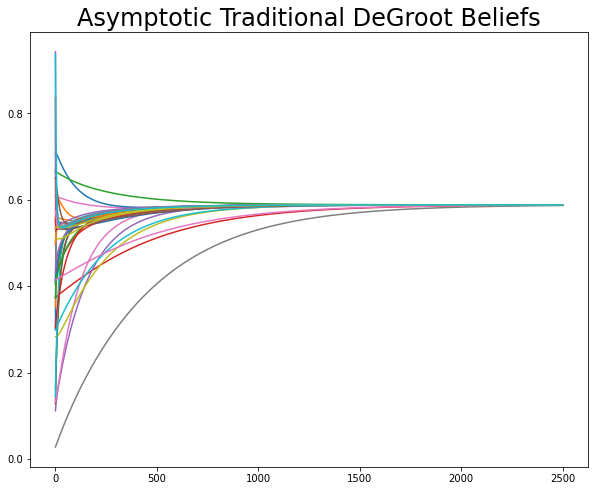

0.588375096819504


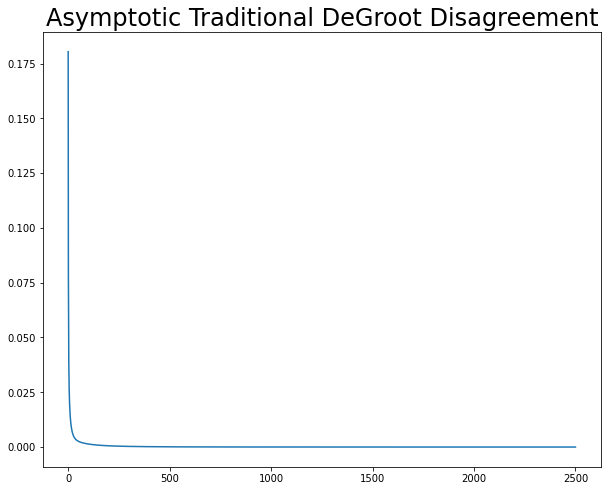

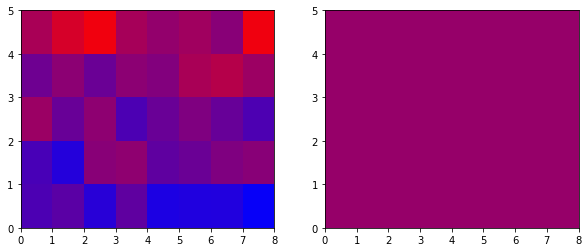

In [106]:
D1 = DeGroot(N, W_degroot, initial_beliefs)
D1.update(2500)
D1.plot_beliefs("Asymptotic Traditional DeGroot Beliefs")
D1.plot_disagreement("Asymptotic Traditional DeGroot Disagreement")
D1.plot_before_and_after("Agent Opinions Before and After DeGroot")

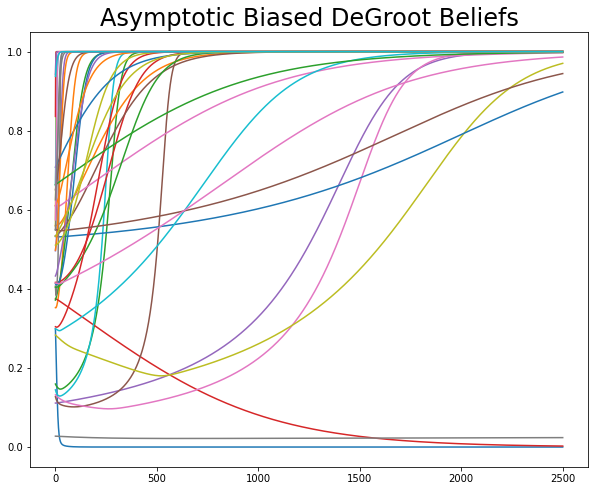

0.9205213647809568


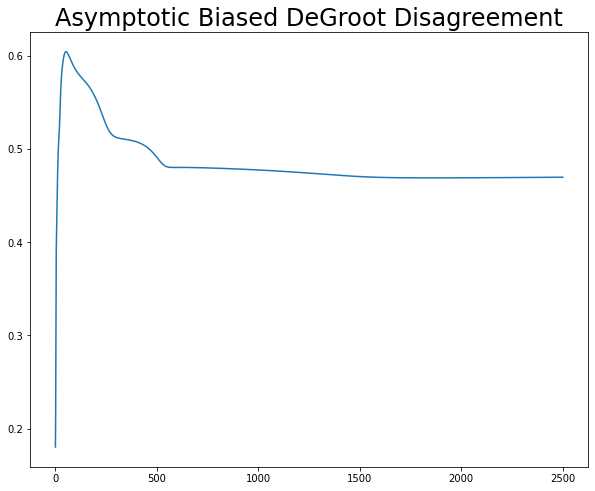

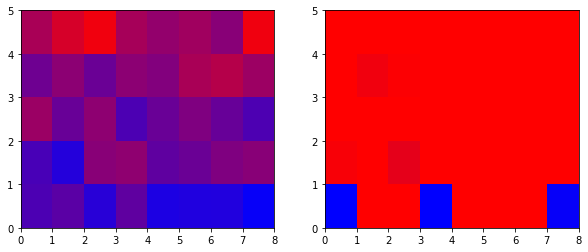

In [107]:
# TODO: Add bias vector into input
bias = np.repeat(2, N)
D2 = DeGroot(N, W_degroot, initial_beliefs, bias=bias)
D2.biased_update(2500)
D2.plot_beliefs("Asymptotic Biased DeGroot Beliefs")
D2.plot_disagreement("Asymptotic Biased DeGroot Disagreement")
D2.plot_before_and_after("Agent Opinions Before and After Biased DeGroot")

## Bounded Confidence Models

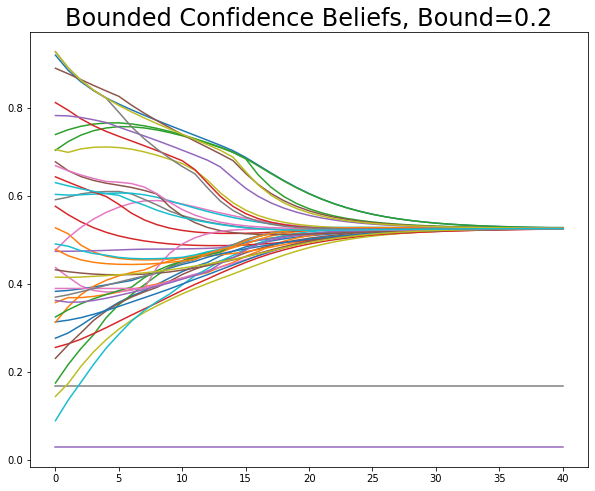

0.5037726796022189


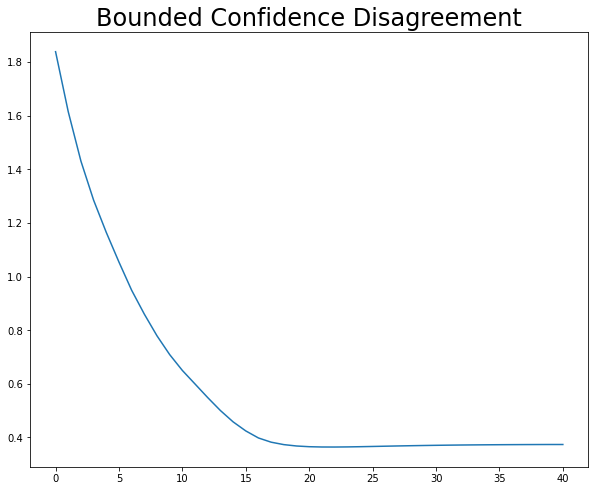

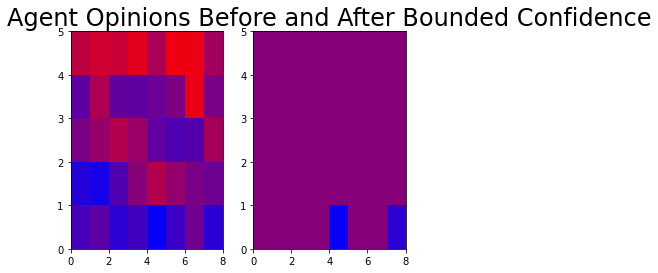

In [73]:
eps = 0.2
B1 = BoundedConfidenceModel(N, W, initial_beliefs, epsilon=eps)
B1.update(40)
B1.plot_beliefs(f"Bounded Confidence Beliefs, Bound={eps}")
B1.plot_disagreement("Bounded Confidence Disagreement")
B1.plot_before_and_after("Agent Opinions Before and After Bounded Confidence")

In [75]:
# Rewiring: Each connection outside epsilon is randomly rewired to one something within epsilon
def rewire(W, opinions, eps):
    N = W.shape[0]
    W_rewired = np.array(W, copy=True)
    for i in range(N):
        for j in range(N):
            # get differences between connections
            if abs(opinions[i] - opinions[j]) > eps:
                within_eps = abs(opinions[i] - opinions) < eps
                unconnected = W[i] == 0
                # connection has to a) not exist previously, and b) not previously connected
                valid_neighbors = np.all(np.vstack((within_eps, unconnected)), axis=0)
                valid_neighbors[i] = False
                candidates = np.arange(N)[valid_neighbors]
                if len(candidates) > 0:
                    new_target = np.random.choice(np.arange(N)[candidates])
                    W_rewired[i][new_target] = 1
                    W_rewired[i][j] = 0
                else:
                    pass
                    # print(f"Could not rewire, connection between {i}-{j} removed")
    return W_rewired

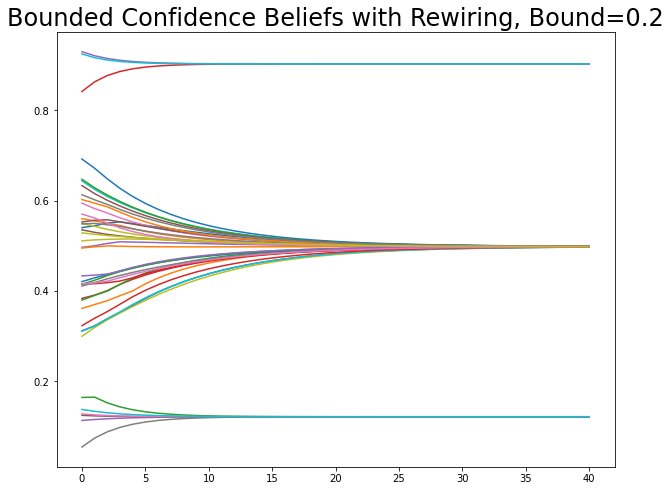

0.471938916772061


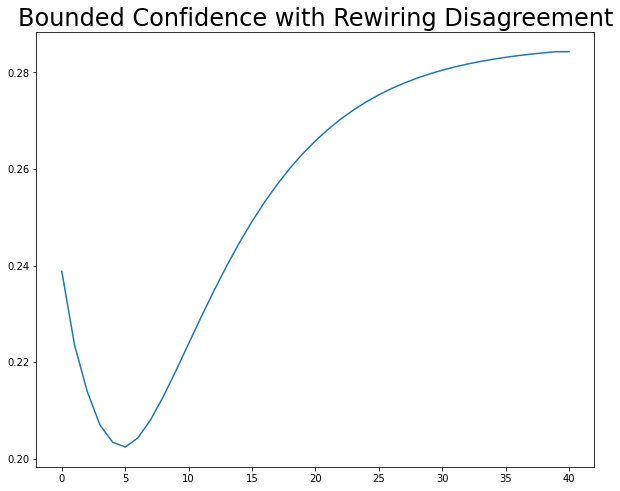

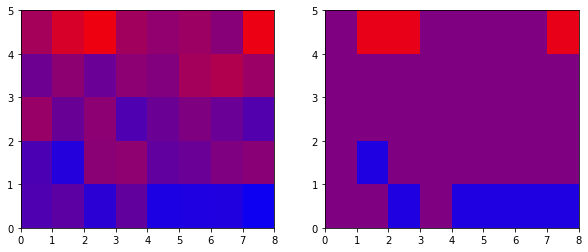

In [109]:
import math

# TODO: Implement rewiring
eps = 0.2
G_rewired = rewire(G_total, initial_beliefs, eps)
W_rewired = np.divide(G_rewired, np.sum(G_rewired, axis=1).reshape(N, 1))
B2 = BoundedConfidenceModel(N, W_rewired, initial_beliefs, epsilon=0.15)
B2.update(40)
B2.plot_beliefs(f"Bounded Confidence Beliefs with Rewiring, Bound={eps}")
B2.plot_disagreement("Bounded Confidence with Rewiring Disagreement")
B2.plot_before_and_after("Agent Opinions Before and After Rewiring")

## Voter Model


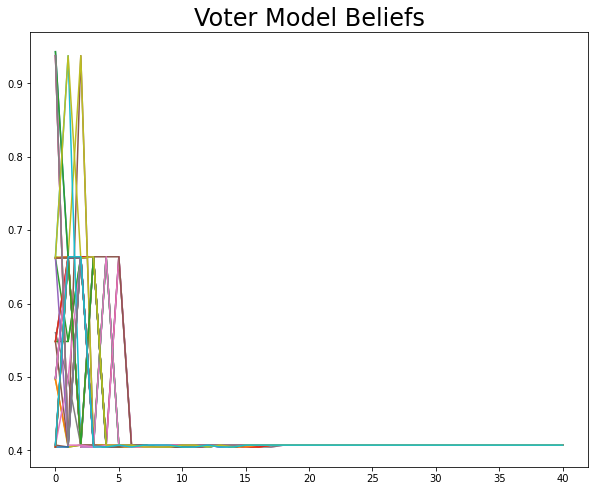

0.40709784099124074


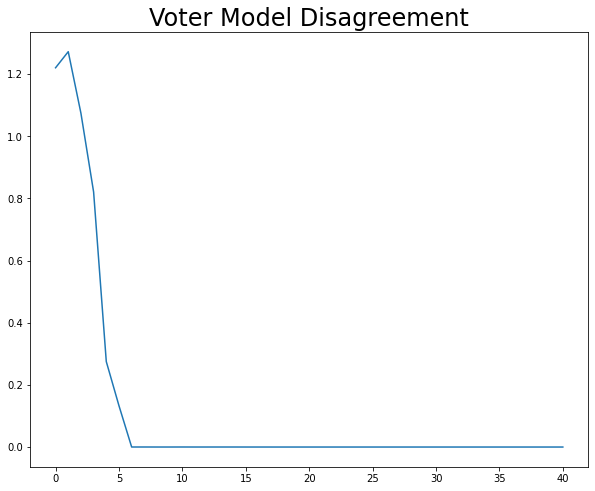

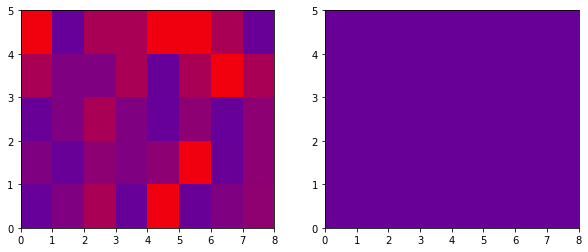

In [110]:
V1 = VoterModel(N, W, initial_beliefs)
V1.update(40)
V1.plot_beliefs("Voter Model Beliefs")
V1.plot_disagreement("Voter Model Disagreement")
V1.plot_before_and_after("Agent Opinions Before and After Voter Model")

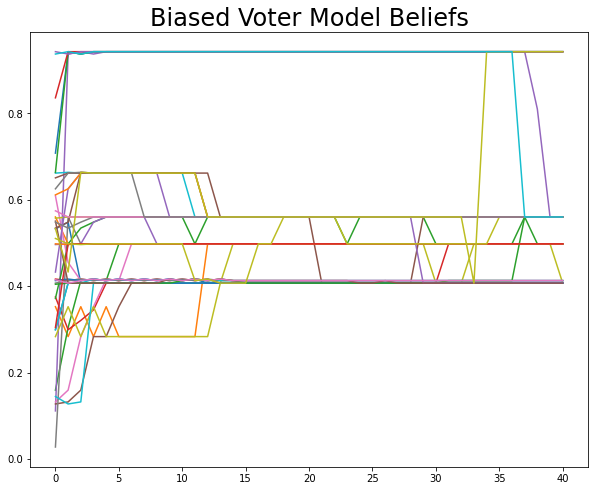

0.5433580167944466


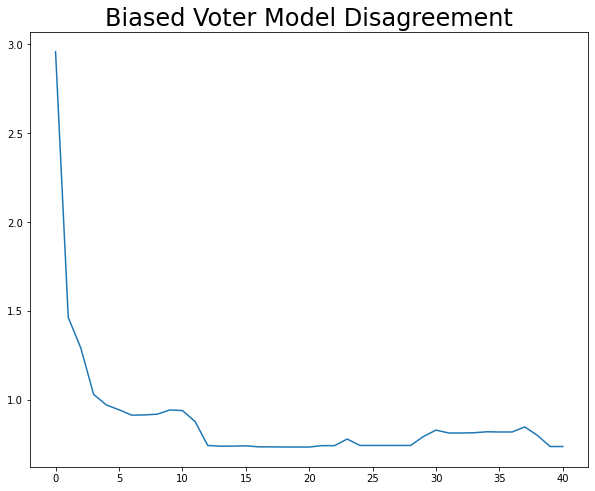

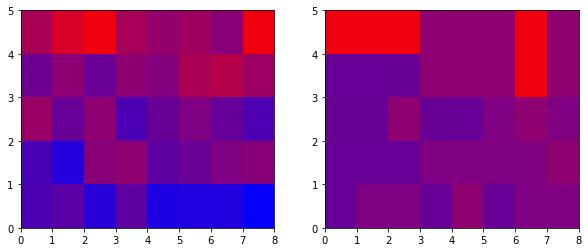

In [111]:
bias = np.repeat(0.9, N)
stubbornness = np.repeat(0.5, N)
V2 = VoterModel(N, W, initial_beliefs, bias, stubbornness)
V2.biased_update(40)
V2.plot_beliefs("Biased Voter Model Beliefs")
V2.plot_disagreement("Biased Voter Model Disagreement")
V2.plot_before_and_after("Agent Opinions Before and After Biased Voter Model")

In [ ]:
np.random.random()

0.7439508994876891

## Temporal DeGroot

In [ ]:
class TemporalDeGroot(SocialLearning):
    def __init__(self, N, W=None, initial_states=None, bias=None):
        self.W = W
        self.N = N
        self.beliefs = np.array([initial_states])
        if bias is None:
            bias = np.zeros(N)
        self.bias = bias
        assert(np.all(self.beliefs <= 1))
        assert(np.all(self.beliefs >= 0))

    def update(self, iterations=1):
        for iteration in range(self.W.shape[0]):
            W = np.array(self.W[iteration], copy=True)
            old_beliefs = self.beliefs[-1]
            new_beliefs = old_beliefs @ W.T
            assert(np.all(new_beliefs <= 1))
            assert(np.all(new_beliefs >= 0))
            self.beliefs = np.vstack((self.beliefs, new_beliefs))

    # Based on the update rule from Dandekar Goel and Lee
    # https://www.pnas.org/content/pnas/110/15/5791.full.pdf
    def biased_update(self, iterations=1):
        for iteration in range(self.W.shape[0]):
            W = np.array(self.W[iteration], copy=True)
            old_beliefs = self.beliefs[-1]
            new_beliefs = np.zeros(self.N)
            self_weights = np.diag(W)
            s_t = old_beliefs @ (W.T - np.diag(self_weights)) # beliefs of neighbors
            d = np.sum(W, axis=1) - self_weights # weighted degree of neighbors

            for i in range(self.N):
                xit = old_beliefs[i]
                bi = self.bias[i]
                num = W[i][i] * xit + xit**bi * s_t[i]
                denom = W[i][i] + xit**bi*s_t[i] + (1-xit)**bi * (d[i] - s_t[i])
                new_beliefs[i] = num / denom
            self.beliefs = np.vstack((self.beliefs, new_beliefs))

In [ ]:
np.any(np.isnan(W_temp))

False

(40, 40, 40)


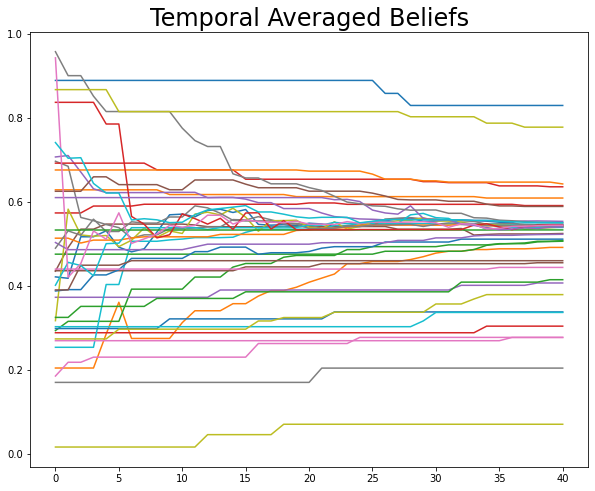

0.49263745378020724


In [ ]:
W_temp = np.array(G, copy=True)
print(W_temp.shape)
H = TemporalDeGroot(N, W_temp, initial_beliefs)
H.update()
H.plot_beliefs("Temporal Averaged Beliefs")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a4d9436-bd2e-42a1-aa25-24ccf8aa8f70' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>